# P7 
## Import et préparation des données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Manual Setting

In [2]:
BaselineTraining = True
LogisticRegression = False
RandomForest = False

PolynomialFeaturesTesting = False
DomainFeaturesTesting = False

In [3]:
app_test = pd.read_csv("../../../CSV-Excels/P7_datasets/application_test.csv")
app_train = pd.read_csv("../../../CSV-Excels/P7_datasets/application_train.csv")
bureau = pd.read_csv("../../../CSV-Excels/P7_datasets/bureau.csv")
bureau_balance = pd.read_csv("../../../CSV-Excels/P7_datasets/bureau_balance.csv")
# credit_card_balance = pd.read_csv("../../../CSV-Excels/P7_datasets/credit_card_balance.csv")
home_credit = pd.read_csv("../../../CSV-Excels/P7_datasets/HomeCredit_columns_description.csv", encoding_errors="ignore")
# installments_payments = pd.read_csv("../../../CSV-Excels/P7_datasets/installments_payments.csv")
# pos_cash_balance = pd.read_csv("../../../CSV-Excels/P7_datasets/POS_CASH_balance.csv")
previous_application = pd.read_csv("../../../CSV-Excels/P7_datasets/previous_application.csv")

### Reduce Memory Allotted Size

In [4]:
def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }

    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }

    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }

    pos_bal = pd.read_csv("../../../CSV-Excels/P7_datasets/POS_CASH_balance.csv", dtype=pos_dtype)
    install = pd.read_csv("../../../CSV-Excels/P7_datasets/installments_payments.csv", dtype=install_dtype)
    card_bal = pd.read_csv("../../../CSV-Excels/P7_datasets/credit_card_balance.csv", dtype=card_dtype)

    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

In [5]:
print(f'Training Data Shape: {app_train.shape}')
print(f'Testing Data Shape: {app_test.shape}')
app_test.head()

Training Data Shape: (307511, 122)
Testing Data Shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit
# (pour les clients qui ont un prêt dans notre échantillon).
# Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que
# le client avait dans le Credit Bureau avant la date de la demande.
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [7]:
# Soldes mensuels des crédits antérieurs au bureau de crédit.
# Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signaléau bureau de crédit
# cad que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs *
# # de mois où nous avons un historique observable pour les crédits précédents) lignes .

bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [8]:
# Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
# Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit 
# (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon
# cad que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * 
# # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.
card_bal

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000000,45000,NaN,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000000,45000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.968750,585000,270000.0,270000.0,0.0,0.0,2250.000000,...,273093.968750,273093.968750,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000000,450000,NaN,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,NaN,0,NaN,NaN,0.0,Active,0,0


In [9]:
# columns description
print(home_credit.iloc[1,3])
home_credit

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [10]:
# Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
# Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
# Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent
# crédit immobilier lié aux crédits de notre échantillon.
install

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500000,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500000,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.433594,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500000,NaN


In [11]:
# Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur
# avait contractés avec Home Credit. Ce tableau a une ligne pour chaque mois d'historique de chaque
# crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie)lié aux prêts de notre échantillon
# cad que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * 
#     # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).
pos_bal

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [12]:
# Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
# Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


# EDA
## Data Imbalanced

TARGET
0    282686
1     24825
dtype: int64


<AxesSubplot:ylabel='Frequency'>

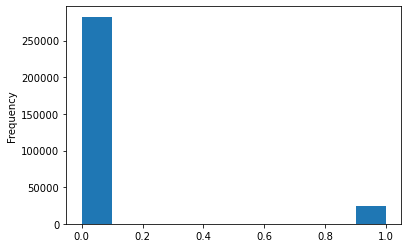

In [13]:
print(app_train.value_counts('TARGET'))
app_train['TARGET'].astype(int).plot.hist()

### Missing values

In [7]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [15]:
missing_values = missing_values_table(app_train)
missing_values.head()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


In [16]:
# app_test = pd.read_csv("../../../CSV-Excels/P7_datasets/application_test.csv")
# app_train = pd.read_csv("../../../CSV-Excels/P7_datasets/application_train.csv")
# bureau = pd.read_csv("../../../CSV-Excels/P7_datasets/bureau.csv")
# bureau_balance = pd.read_csv("../../../CSV-Excels/P7_datasets/bureau_balance.csv")
# # credit_card_balance = pd.read_csv("../../../CSV-Excels/P7_datasets/credit_card_balance.csv")
# home_credit = pd.read_csv("../../../CSV-Excels/P7_datasets/HomeCredit_columns_description.csv", encoding_errors="ignore")
# # installments_payments = pd.read_csv("../../../CSV-Excels/P7_datasets/installments_payments.csv")
# # pos_cash_balance = pd.read_csv("../../../CSV-Excels/P7_datasets/POS_CASH_balance.csv")
# # previous_application = pd.read_csv("../../../CSV-Excels/P7_datasets/previous_application.csv")

In [17]:
# delete columns
columns_to_delete = missing_values[missing_values["% of Total Values"] > 58].index
print(len(columns_to_delete), "columns have a lot of missing values (>58%), they will be deleted")
app_train.drop(columns=columns_to_delete, inplace=True)
app_test.drop(columns=columns_to_delete, inplace=True)

23 columns have a lot of missing values (>58%), they will be deleted


### Data types in my dataset

In [18]:
app_train.dtypes.value_counts()

float64    43
int64      41
object     15
dtype: int64

In [19]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Encoding Categorical Variables

For categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories.

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [20]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [21]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 217)
Testing Features shape:  (48744, 213)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data.

In [22]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)


Training Features shape:  (307511, 214)
Testing Features shape:  (48744, 213)


In [23]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

10       365243
17       365243
22       365243
26       365243
36       365243
          ...  
48717    365243
48728    365243
48731    365243
48735    365243
48736    365243
Name: DAYS_EMPLOYED, Length: 9274, dtype: int64

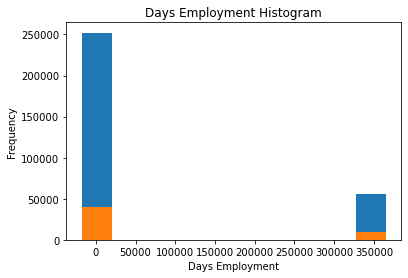

In [24]:
import matplotlib.pyplot as plt

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] > 200000]


In [25]:
# Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

We will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.


There are 9274 anomalies in the test data out of 48744 entries



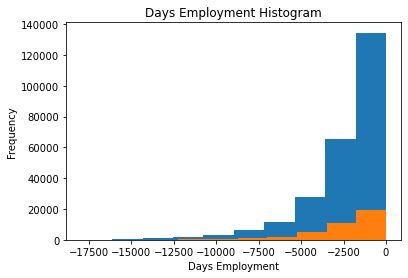

In [26]:

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

print('There are %d anomalies in the test data out of %d entries\n' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Correlations

In [27]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))


Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Effect of Age on Repayment

In [28]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

### Distribution of Age

Text(0, 0.5, 'Count')

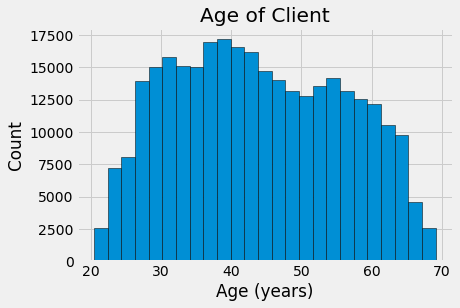

In [29]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of Ages')

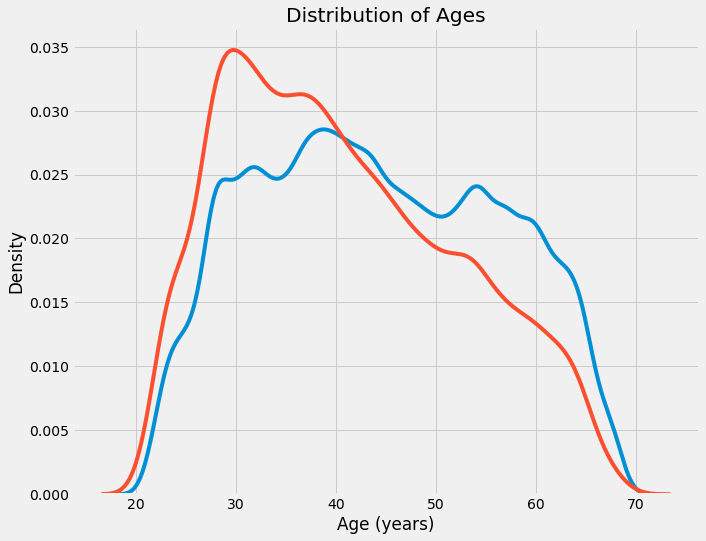

In [30]:
import seaborn as sns

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient),
this variable is likely going to be useful in a machine learning model because it does affect the target.
Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin,
    we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [31]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)


/tmp/ipykernel_11444/1622345730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/tmp/ipykernel_11444/1622345730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [32]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

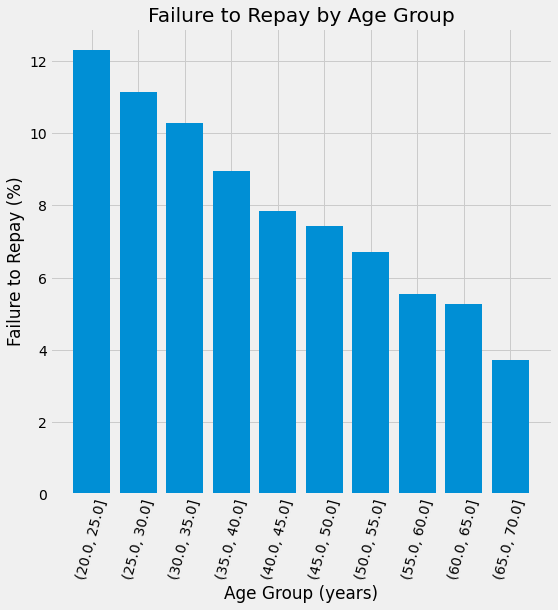

In [33]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3.

In [34]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

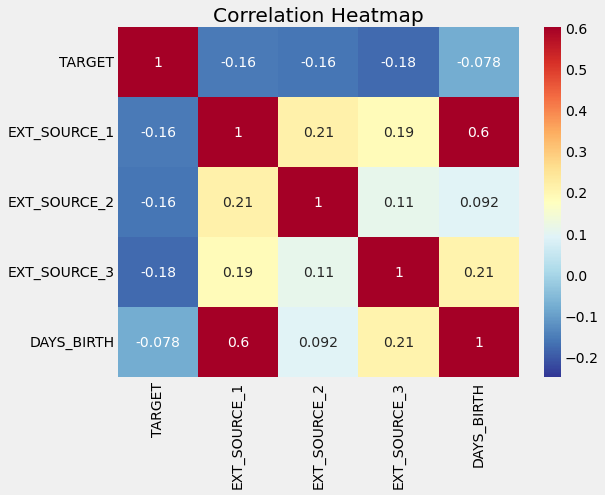

In [35]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

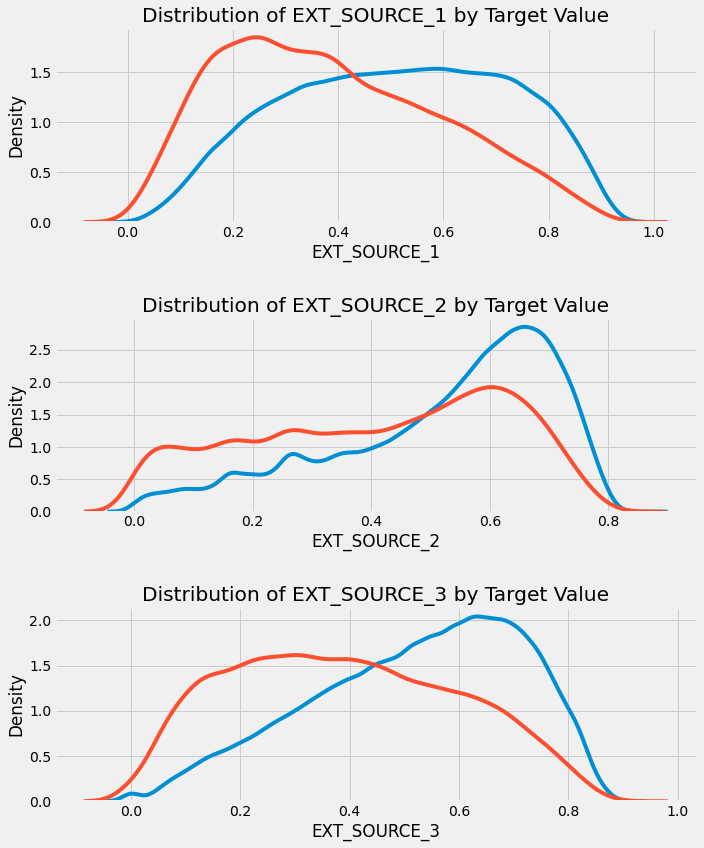

In [36]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Feature Engineering (Example)

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. This represents one of the patterns in machine learning: Feature engineering has a greater return on investment than model building and hyperparameter tuning. As Andrew Ng is fond of saying: Applied machine learning is basically feature engineering.

Polynomial Features

In [37]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [38]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)


Polynomial Features shape:  (307511, 35)


In [39]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [40]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.194235
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189593
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181417
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176589
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.171729
EXT_SOURCE_1 EXT_SOURCE_2                -0.166538
EXT_SOURCE_1 EXT_SOURCE_3                -0.164933
EXT_SOURCE_2                             -0.160303
EXT_SOURCE_3                             -0.157397
EXT_SOURCE_2 DAYS_BIRTH                  -0.156879
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


We will add these features to a copy of the training and testing data and then evaluate models with and without the features. The only way to know if an approach will work is to try it out!

In [41]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polynomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 249)
Testing data with polynomial features shape:   (48744, 249)


### Domain Knowledge Features

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

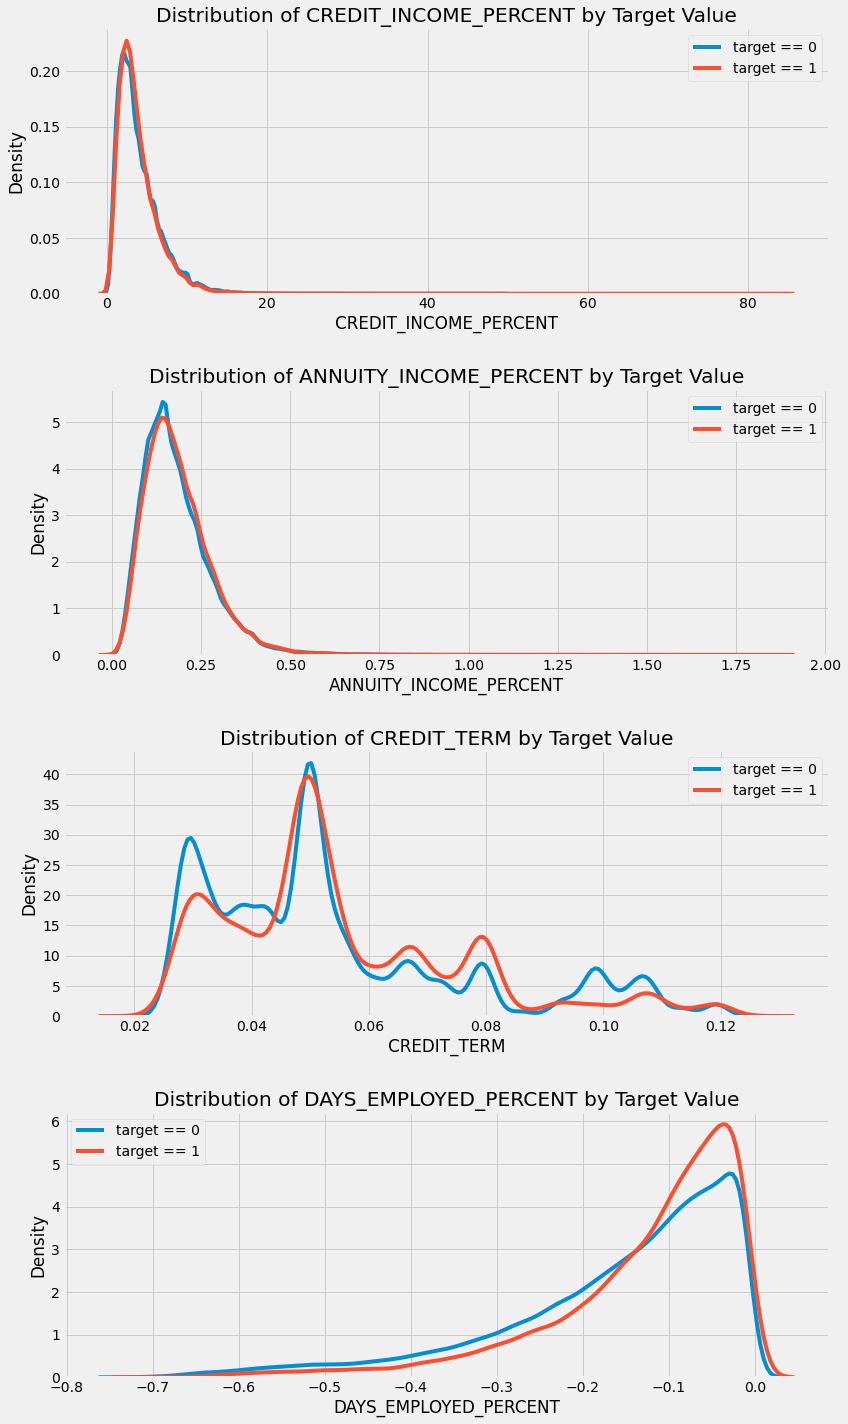

In [42]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # matplotlib.pyplot.legend
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    plt.legend()
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Feature Engineering (Final)

In [43]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE_X FEATURE 
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    
    return apps

In [44]:
def get_prev_processed(prev):
    """
    feature engineering 
    for previouse application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    # Data Cleansing
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # 1.Calculate the interest rate
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_processed(prev):
    """
    feature engineering 
    for previouse application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    # Data Cleansing
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

    # substraction between DAYS_LAST_DUE_1ST_VERSION and DAYS_LAST_DUE
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # 1.Calculate the interest rate
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_amt_agg(prev):
    """
    feature engineering for the previous credit appliction
    """

    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    """
    PREV_APPROVED_COUNT : Credit application approved count
    PREV_REFUSED_COUNT :  Credit application refused count
    """
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    # unstack() 
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

    # rename column 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]

    # NaN
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

    return prev_refused_appr_agg

def get_prev_days365_agg(prev):
    """
    DAYS_DECISION means How many days have been take since the previous credit application made.
    Somehow this feature is important.
    """
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    # multi index 
    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR APPROVED_COUNT REFUSED_COUNT
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [45]:
def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

def get_bureau_active_agg(bureau):
    '''
    Bureau CREDIT_ACTIVE='Active' filtering
    SK_ID_CURR aggregation
    '''
    # CREDIT_ACTIVE='Active' filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # SK_ID_CURR reset_index() 
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# BUREAU DAYS_CREDIT -750
def get_bureau_days750_agg(bureau):
    cond_days750 = bureau['DAYS_CREDIT'] > -750
    bureau_days750_group = bureau[cond_days750].groupby('SK_ID_CURR')
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }
    
    bureau_days750_agg = bureau_days750_group.agg(bureau_agg_dict)
    bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_days750_agg.columns.ravel()]
    bureau_days750_agg = bureau_days750_agg.reset_index()
    
    return bureau_days750_agg

# bureau_bal SK_ID_CURR MONTHS_BALANCE aggregation
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR Group by bureau SK_ID_CURR 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS 120
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR MONTHS_BALANCE aggregation
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # SK_ID_CURR reset_index()
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg

# bureau aggregation
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_days750_agg = get_bureau_days750_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg bureau_active_agg
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS ACTIVE IS_DPD RATIO
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg bureau_bal_agg
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg


In [46]:
def get_pos_bal_agg(pos_bal):
    # (SK_DPD) 0 , 0~ 100 , 100
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 0~ 120 120
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE (20)
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)

    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR reset_index()
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

In [47]:
def get_install_agg(install):
    # DPD  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 30~ 120 100
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

     # (DAYS_ENTRY_PAYMENT) (1)
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg



In [48]:
def get_card_bal_agg(card_bal):
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # SK_ID_CURR aggregation
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE (3)
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

## Training

In [49]:
# if RandomForest:

#     # Make the random forest classifier
#     random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

#     # Train on the training data
#     random_forest.fit(train, train_labels)

#     # Extract feature importances
#     feature_importance_values = random_forest.feature_importances_
#     feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

#     # Make predictions on the test data
#     predictions = random_forest.predict_proba(test)[:, 1]

#     # Make a submission dataframe
#     submit = app_test[['SK_ID_CURR']].copy()
#     submit.loc[:, 'TARGET'] = predictions

#     # submit.head()

#     # Save the submission dataframe
#     submit.to_csv('random_forest_baseline.csv', index = False)
# if PolynomialFeaturesTesting:
#     poly_features_names = list(app_train_poly.columns)

#     poly_features = imputer.fit_transform(app_train_poly)
#     poly_features_test = imputer.transform(app_test_poly)

#     poly_features = scaler.fit_transform(poly_features)
#     poly_features_test = scaler.transform(poly_features_test)

#     random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

#     # Train on the training data
#     random_forest_poly.fit(poly_features, train_labels)

#     # Make predictions on the test data
#     predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

#     # Make a submission dataframe
#     submit = app_test[['SK_ID_CURR']].copy()
#     submit.loc[:, 'TARGET'] = predictions

#     submit.head()

#     # Save the submission dataframe
#     submit.to_csv('random_forest_baseline_engineered.csv', index = False)

# if DomainFeaturesTesting:
#     app_train_domain = app_train_domain.drop(columns = 'TARGET')

#     domain_features_names = list(app_train_domain.columns)

#     domain_features = imputer.fit_transform(app_train_domain)
#     domain_features_test = imputer.transform(app_test_domain)

#     domain_features = scaler.fit_transform(domain_features)
#     domain_features_test = scaler.transform(domain_features_test)

#     random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

#     # Train on the training data
#     random_forest_domain.fit(domain_features, train_labels)

#     # Extract feature importances
#     feature_importance_values_domain = random_forest_domain.feature_importances_
#     feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

#     # Make predictions on the test data
#     predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

#     # Make a submission dataframe
#     submit = app_test[['SK_ID_CURR']].copy()
#     submit.loc[:, 'TARGET'] = predictions

#     # Save the submission dataframe
#     submit.to_csv('random_forest_baseline_domain.csv', index = False)

## Feature Importances (Example)

In [1]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [51]:
# feature_importances_sorted = plot_feature_importances(feature_importances)

In [52]:
# feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

## Reload The Original Datasets For Final Training

In [53]:
# Datasets Concatenation and Join
def get_apps_all_with_all_agg(app, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    """
    Description :
    1.Data preparation , aggregation 
    2.produce the finalized result
    """
    app_all =  get_apps_processed(app)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    print('prev_agg shape:', prev_agg.shape, 'bureau_agg shape:', bureau_agg.shape )
    print('pos_bal_agg shape:', pos_bal_agg.shape, 'install_agg shape:', install_agg.shape, 'card_bal_agg shape:', card_bal_agg.shape)
    print('apps_all before merge shape:', app_all.shape)

    # Join all
    app_all = app_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    app_all = app_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    app_all = app_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    app_all = app_all.merge(install_agg, on='SK_ID_CURR', how='left')
    app_all = app_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')

    # app_all = app_all.merge(prev, on='SK_ID_CURR', how='left')
    # app_all = app_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    # app_all = app_all.merge(pos_bal, on='SK_ID_CURR', how='left')
    # app_all = app_all.merge(install, on='SK_ID_CURR', how='left')
    # app_all = app_all.merge(card_bal, on='SK_ID_CURR', how='left')

    print('data after merge with all shape:', app_all.shape)

    return app_all

In [54]:
data = get_apps_all_with_all_agg(app_train, previous_application, bureau, bureau_balance, pos_bal, install, card_bal)

/tmp/ipykernel_11444/3482123234.py:83: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
/tmp/ipykernel_11444/3482123234.py:133: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]
/tmp/ipykernel_11444/372019911.py:119: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
/tmp/ipykernel_11444/372019911.py:151: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  bureau_days750_agg.columns = ['BUREAU_ACT_'+('_').join(column).uppe

prev_agg shape: (338857, 80) bureau_agg shape: (305811, 149)
pos_bal_agg shape: (337252, 45) install_agg shape: (339587, 59) card_bal_agg shape: (103558, 70)
apps_all before merge shape: (307511, 226)
data after merge with all shape: (307511, 625)


## Checkpoint - Load data from CSV

In [3]:

# data.to_csv('data_agg.csv', index=False)
data = pd.read_csv('data_agg.csv')

In [4]:
print(data.dtypes.value_counts())
data

float64    454
int64      170
bool         1
dtype: int64


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CARD_M3BALANCE_LIMIT_RATIO_MIN,CARD_M3BALANCE_LIMIT_RATIO_MAX,CARD_M3DRAWING_LIMIT_RATIO_MIN,CARD_M3DRAWING_LIMIT_RATIO_MAX,CARD_M3CARD_IS_DPD_MEAN,CARD_M3CARD_IS_DPD_SUM,CARD_M3CARD_IS_DPD_UNDER_120_MEAN,CARD_M3CARD_IS_DPD_UNDER_120_SUM,CARD_M3CARD_IS_DPD_OVER_120_MEAN,CARD_M3CARD_IS_DPD_OVER_120_SUM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# # missing_values_table(data)
# missing_values_in_data = missing_values_table(data)
# columns_to_delete = missing_values_in_data[missing_values_in_data["% of Total Values"] > 58].index
# print(len(columns_to_delete), "columns have a lot of missing values (>58%), they will be deleted")
# data.drop(columns=columns_to_delete, inplace=True)

# # Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [6]:
# inf_values = df[df.isin([np.inf, -np.inf])]

# # # Comptage des lignes et des colonnes avec des valeurs infinies
# rows_with_inf = inf_values.any(axis=1).sum()
# cols_with_inf = inf_values.any(axis=0).sum()

# # # Affichage des résultats
# print("Nombre de lignes avec des valeurs infinies : {}".format(rows_with_inf))
# print("Nombre de colonnes avec des valeurs infinies : {}".format(cols_with_inf))

# # # Recherche des colonnes avec des valeurs infinies
# inf_columns = inf_values.any(axis=0)

# # # Affichage des colonnes avec des valeurs infinies
# print("Les colonnes avec des valeurs infinies sont :")
# print(df.columns[inf_columns])

## Checkpoint - Load data cleaned from CSV

In [24]:
# data.to_csv('data_cleaned.csv', index=False)
# data = pd.read_csv('data_cleaned.csv')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, f1_score, make_scorer, fbeta_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
class RenameColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in X.columns]
        print('Columns are renamed correctly')
        return X

# class TruncateValues(BaseEstimator, TransformerMixin):
#     def __init__(self, threshold=10000000, threshold_neg=-10000000):
#         self.threshold = threshold
#         self.threshold_neg = threshold_neg

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X[X > self.threshold] = self.threshold
#         X[X < self.threshold_neg] = self.threshold_neg
#         print('Values are truncated')
#         return X

class RemoveInfValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X = X.astype(float)
        # inf_values = X[X.isin([np.inf, -np.inf])]
        # inf_columns = inf_values.any(axis=0)
        # cols_with_inf_values = X.columns[inf_columns]
        # X = X.drop(columns=cols_with_inf_values)
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        # X = X.apply(pd.to_numeric, errors='coerce')
        # X = X.copy()
        # X.replace([np.inf, -np.inf], np.nan, inplace=True)
        # column_medians = X.median()
        # X.fillna(column_medians, inplace=True)
        X.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in X.columns]
        print('Columns are renamed correctly')
        print('Inf values to NaN worked')
        column_medians = X.median()
        X.fillna(column_medians, inplace=True)
        print('Values imputed')
        return X

class ImputeValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        column_medians = X.median()
        X.fillna(column_medians, inplace=True)
        print('Values imputed')
        return X

# class PrintValues(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         print('Print inf values')
#         print(max(X.max().to_list()))
#         return X

In [9]:
# # Handle missing values
# missing_val_percent = 100 * data.isnull().sum() / len(data)
# missing_columns = missing_val_percent[missing_val_percent > 58].index
# data.drop(columns=missing_columns, inplace=True)
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
# median = data.median()
# data.fillna(median, inplace=True)

# # Handle columns name
# data.columns = [re.sub('[^0-9a-zA-Z]+', '_', col) for col in data.columns]

In [5]:
df = data.drop(['SK_ID_CURR', 'TARGET', 'DAYS_EMPLOYED_ANOM'], axis=1)
all_features = df.columns

categorical_features = []
for columnn in df.columns:
    if len(df[columnn].unique()) == 2 and set(df[columnn].unique()) == set([0, 1]):
        categorical_features.append(columnn)

# bool_features = df.select_dtypes(include=bool).columns.tolist()

numeric_features = df.drop(columns=categorical_features).columns

param_grid_log = {
        'preprocessor__num_scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['saga'],
        'classifier__class_weight': ['balanced'],
    }

param_grid_lgbm = {
        'preprocessor__num_scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'classifier__max_depth': [None, 10],
        'classifier__n_estimators': [100, 1000],
        'classifier__class_weight': ['balanced'],
    }

param_grid_rfc = {
        'preprocessor__num_scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'classifier': [RandomForestClassifier()],
        'classifier__max_depth': [None, 10],
        'classifier__n_estimators': [100, 1000],
        'classifier__class_weight': ['balanced'],
    }

f10_score = make_scorer(fbeta_score, beta=10)

In [6]:
column_transformer = ColumnTransformer(
        transformers=[
            # ('truncate_values', TruncateValues(), all_features),
            # ('impute_median', SimpleImputer(strategy='median'), all_features),
            # ('print_values', PrintValues(), all_features),
            # ('rename_columns', RenameColumns(), all_features),
            ('remove_inf', RemoveInfValues(), all_features),
            # ('impute_values', ImputeValues(), all_features),
            # ('num_scaler', StandardScaler(), numeric_features),

            # ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            # ('bool_encoder', OrdinalEncoder(dtype=int), bool_features)
        ]
    )

num_scaler_transformer = ColumnTransformer(
        # transformers=[('num_scaler', StandardScaler(), numeric_features)]
        transformers=[('num_scaler', StandardScaler(), all_features)]
    )

# Création de la pipeline
pipeline_log = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', LogisticRegression(solver="liblinear"))
])

pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', num_scaler_transformer),
    ('classifier', LGBMClassifier())
])

pipeline_preprocessing = Pipeline(steps=[
    ('preprocessor', column_transformer)
])

pipeline_rfc = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', RandomForestClassifier())
])

In [7]:
# Prepare data for splitting
data_0 = data[data['TARGET'] == 0]
data_1 = data[data['TARGET'] == 1]
data_0 = data_0.sample(n=200, replace=False, random_state=2023, ignore_index=True)
data_1 = data_1.sample(n=100, replace=False, random_state=2023, ignore_index=True)
data_balanced = pd.concat([data_0, data_1], axis=0)

data_to_split = data_balanced.drop(['SK_ID_CURR', 'TARGET', 'DAYS_EMPLOYED_ANOM'], axis=1)
target = data_balanced['TARGET']

# data_processed = pipeline_preprocessing.fit_transform(data_to_split)


In [8]:

X_train, X_test, y_train, y_test = train_test_split(data_to_split, target, test_size=0.2, random_state=2023)

In [9]:
X_train

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INS_D365AMT_RATIO_MAX,INS_D365SK_DPD_MEAN,INS_D365SK_DPD_MIN,INS_D365SK_DPD_MAX,INS_D365INS_IS_DPD_MEAN,INS_D365INS_IS_DPD_SUM,INS_D365INS_IS_DPD_UNDER_120_MEAN,INS_D365INS_IS_DPD_UNDER_120_SUM,INS_D365INS_IS_DPD_OVER_120_MEAN,INS_D365INS_IS_DPD_OVER_120_SUM
158,0,1,0,2,382500.0,2013840.0,57843.0,1800000.0,0.031329,12395,...,1.0,-8.200000,-21.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
180,0,1,1,0,270000.0,1082214.0,31770.0,945000.0,0.022625,19611,...,1.0,-8.600000,-24.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
46,0,0,1,1,112500.0,225000.0,13045.5,225000.0,0.028663,24134,...,1.0,-7.800000,-23.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
149,0,1,1,0,112500.0,867951.0,30879.0,724500.0,0.008068,18689,...,1.0,-8.200000,-21.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
150,0,0,1,1,157500.0,1288350.0,34114.5,1125000.0,0.030755,13610,...,1.0,-20.466667,-74.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,0,0,0,0,85500.0,755190.0,29947.5,675000.0,0.005313,23230,...,1.0,-48.000000,-61.0,-24.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0,1,1,1,270000.0,891072.0,35469.0,720000.0,0.018029,16479,...,1.0,-6.900000,-30.0,6.0,0.500000,5.0,0.500000,5.0,0.0,0.0
20,0,1,1,2,157500.0,592560.0,31153.5,450000.0,0.020713,11666,...,1.0,-1.000000,-11.0,9.0,0.500000,1.0,0.500000,1.0,0.0,0.0
183,0,0,1,3,157500.0,161730.0,13095.0,135000.0,0.025164,12709,...,1.0,-5.851852,-17.0,5.0,0.037037,1.0,0.037037,1.0,0.0,0.0


In [11]:

X_train_trans = pipeline_preprocessing.fit_transform(X_train)
print(X_train_trans.shape)
X_test_trans = pipeline_preprocessing.transform(X_test)
# X_train_trans = empty_column_transformer.fit_transform(X_train_trans)
# X_test_trans = empty_column_transformer.transform(X_test_trans)
print('Train shape:', X_train_trans.shape, 'Test shape:', X_test_trans.shape)

Columns are renamed correctly
Inf values to NaN worked
Values imputed
(240, 489)
Columns are renamed correctly
Inf values to NaN worked
Values imputed
Train shape: (240, 489) Test shape: (60, 489)


In [12]:
# cross_validate(pipeline_log, X_train, y_train, scoring='roc_auc', cv=5, return_train_score=True)
# cross_validate(pipeline_lgbm, X_train, y_train, scoring='roc_auc', cv=5, return_train_score=True)
# cross_validate(pipeline_rfc, X_train, y_train, scoring='roc_auc', cv=5, return_train_score=True)
X_train_dataframe = pd.DataFrame(X_train_trans, columns=X_train.columns)

In [ ]:
# Je fais le choix de partir sur l'algo lgbm pour la suite du projet : utilisation d'une grid search pour trouver les meilleurs hyper paramètres

In [13]:
scoring = {"AUC": "roc_auc", "my_f10_score": f10_score}

grid_search = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring=scoring, return_train_score=True, refit='my_f10_score') # ajouter class weight sur data déséquilibrée
grid_search.fit(X_train_dataframe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_scaler',
                                                                         StandardScaler(),
                                                                         Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'INS_D365AMT_RATIO_MAX', 'INS_D365SK_DPD_ME...
                                       ('classifier', LGBMClassifier())]),
             param_grid={'classifier__class_weight': ['balanced'],
                         'classifier__max_depth': [None, 10],
                         'classifier__n_estimators': [100, 1000],
                         'preprocessor__num_scaler': [StandardScaler(),
                                                      MinMaxScaler(),
                                                      RobustScaler()]},
             refit='my_f10_score', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'my_f10_score': make_scorer(fbeta_score, beta=10)})

In [15]:
results = grid_search.cv_results_
results

{'mean_fit_time': array([0.11883845, 0.05971088, 0.10219917, 0.24164076, 0.20070181,
        0.24924183, 0.05426431, 0.05101519, 0.10096993, 0.2178483 ,
        0.20429668, 0.25246906]),
 'std_fit_time': array([0.11833291, 0.01259195, 0.00368014, 0.06583733, 0.00861434,
        0.00271429, 0.00342412, 0.00419819, 0.00270053, 0.01928295,
        0.02371399, 0.00304215]),
 'mean_score_time': array([0.01285486, 0.01695704, 0.01297274, 0.01341743, 0.01353655,
        0.01349421, 0.01377635, 0.0131331 , 0.0131938 , 0.01485391,
        0.01460752, 0.01342187]),
 'std_score_time': array([1.41319073e-04, 7.61016061e-03, 7.09976102e-05, 1.37508080e-04,
        1.76629816e-04, 2.85482028e-04, 1.11122485e-03, 2.86368342e-04,
        3.43849302e-04, 1.97138742e-03, 8.02341095e-04, 1.52462267e-04]),
 'param_classifier__class_weight': masked_array(data=['balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 'balanced', 'balanced', 'balanced',
                    'balanced', 

In [25]:
mlflow.set_experiment("Metrics LGBM Classifier after Grid Search CV")

# Accéder aux informations de chaque combinaison de paramètres testée
for i in range(len(results['params'])):
    print("Params", results['params'][i])
    print("mean_train_AUC", results['mean_train_AUC'][i])
    print("mean_test_AUC", results['mean_test_AUC'][i])
    print("mean_train_my_f10_score", results['mean_train_my_f10_score'][i])
    print("mean_test_my_f10_score", results['mean_test_my_f10_score'][i])
    print()
    with mlflow.start_run():
        mlflow.log_param("Params grid", results['params'][i])
        mlflow.log_metric("mean_train_AUC", results['mean_train_AUC'][i])
        mlflow.log_metric("mean_test_AUC", results['mean_test_AUC'][i])
        mlflow.log_metric("mean_train_my_f10_score", results['mean_train_my_f10_score'][i])
        mlflow.log_metric("mean_test_my_f10_score", results['mean_test_my_f10_score'][i])

    mlflow.end_run()

with mlflow.start_run():
    # Évaluation du modèle sur les données de test => Number of features of the model must match the input. Model n_features_ is 1614 and input n_features is 489
    best_model = grid_search.best_estimator_.named_steps['classifier']
    # y_pred = best_model.predict(X_test)
    y_pred = best_model.predict(pipeline_preprocessing.transform(X_test))
    f10_score = fbeta_score(y_test, y_pred, beta=10)
    roc_auc_score = roc_auc_score(y_test, y_pred)

    mlflow.sklearn.log_model(best_model, "model")
    mlflow.log_param("Best Model params", best_model)
    mlflow.log_metric("f10_score", f10_score)
    mlflow.log_metric("roc_auc_score", roc_auc_score)

    mlflow.end_run()


In [27]:
best_model.feature_importances_

array([ 0,  0,  2,  0,  0, 12, 17,  9,  5,  6,  5, 16,  5,  0,  0,  0,  0,
        0,  0,  2,  1,  2,  3,  0,  0,  0,  0,  2,  0,  2, 18, 14,  2,  2,
        0,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
        0,  0,  0,  3,  2,  0,  1,  3,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
        2,  2,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0, 40,  9,  8, 24, 10,  1,  0, 14, 14,
        4,  2,  3,  2,  1

In [28]:
# feature importance globale depuis le modèle
import shap

feature_importances = best_model.feature_importances_
indices = list(range(len(feature_importances)))

# Créer une liste de tuples (indice, valeur d'importance)
col_importances = list(zip(indices, feature_importances, df.columns))

col_importances_sorted = sorted(col_importances, key=lambda x: x[1], reverse=True)
top_10_cols = col_importances_sorted[:10]
top_10_indices = [col[0] for col in top_10_cols]
top_10_score = [col[1] for col in top_10_cols]
top_10_columns = df.columns[top_10_indices]
top_10_columns
pd.DataFrame({'Feature_importances_score': top_10_score, 'Col_name' : top_10_columns})

/home/kilian/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/kilian/anaconda3/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, m

,Feature_importances_score,Col_name
0,40,APPS_EXT_SOURCE_MEAN
1,24,APPS_GOODS_CREDIT_RATIO
2,23,BUREAU_BUREAU_CREDIT_DEBT_DIFF_MAX
3,18,EXT_SOURCE_2
4,18,INS_D365DAYS_ENTRY_PAYMENT_MEAN
5,18,INS_D365SK_DPD_MIN
6,17,AMT_ANNUITY
7,17,POS_M20MONTHS_BALANCE_MEAN
8,16,DAYS_REGISTRATION
9,14,EXT_SOURCE_3


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


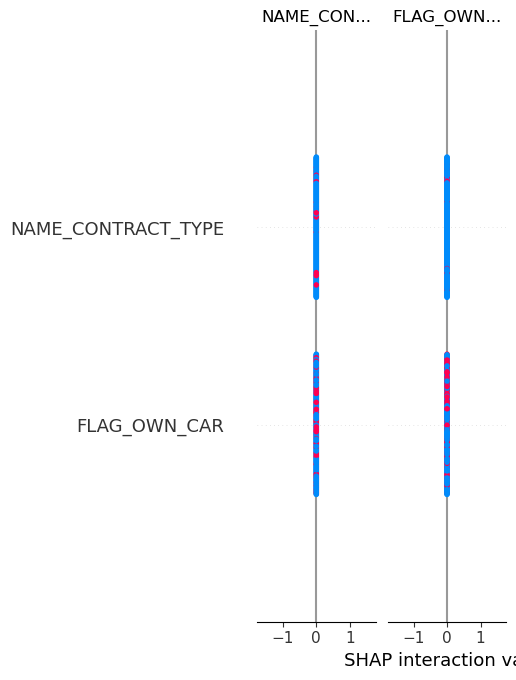

In [54]:
# feature importance globale et personnelle, librairie shap
import shap

# Calculate SHAP values for training set
explainer_train = shap.Explainer(best_model)

X_train_scaled = num_scaler_transformer.fit_transform(X_train_dataframe)

shap_values_train = explainer_train(X_train_scaled)
# shap_values_train
shap.summary_plot(shap_values_train, X_train, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


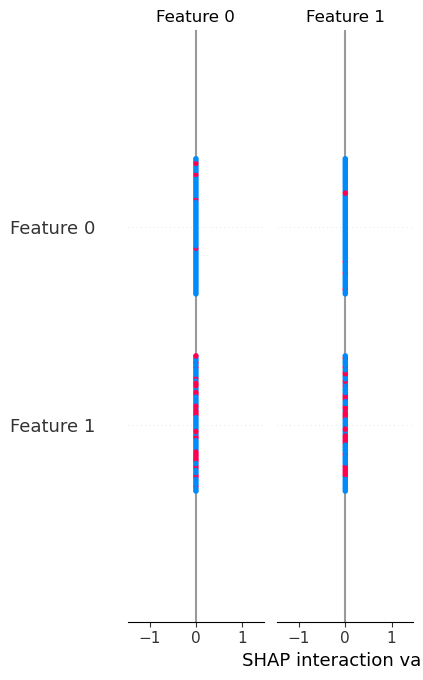

In [55]:

# Calculate SHAP values for test set
explainer_test = shap.Explainer(best_model)

num_scaler_transformer.fit(X_train_dataframe)
X_test_dataframe = pd.DataFrame(X_test_trans, columns=X_train.columns)
X_test_scaled = num_scaler_transformer.transform(X_test_dataframe)

shap_values_test = explainer_test(X_test_scaled)
shap_values_test

shap.summary_plot(shap_values_test, X_test_scaled)

In [80]:

# Visualiser les graphiques d'explication individuelle
# shap.force_plot(explainer_train.expected_value[0], shap_values_train[0])
# explainer_train.expected_value
# shap_values_train[0].shape
# X_train_scaled[0,:].shape

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [85]:
shap.initjs()

In [86]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train_dataframe.iloc[0,:])

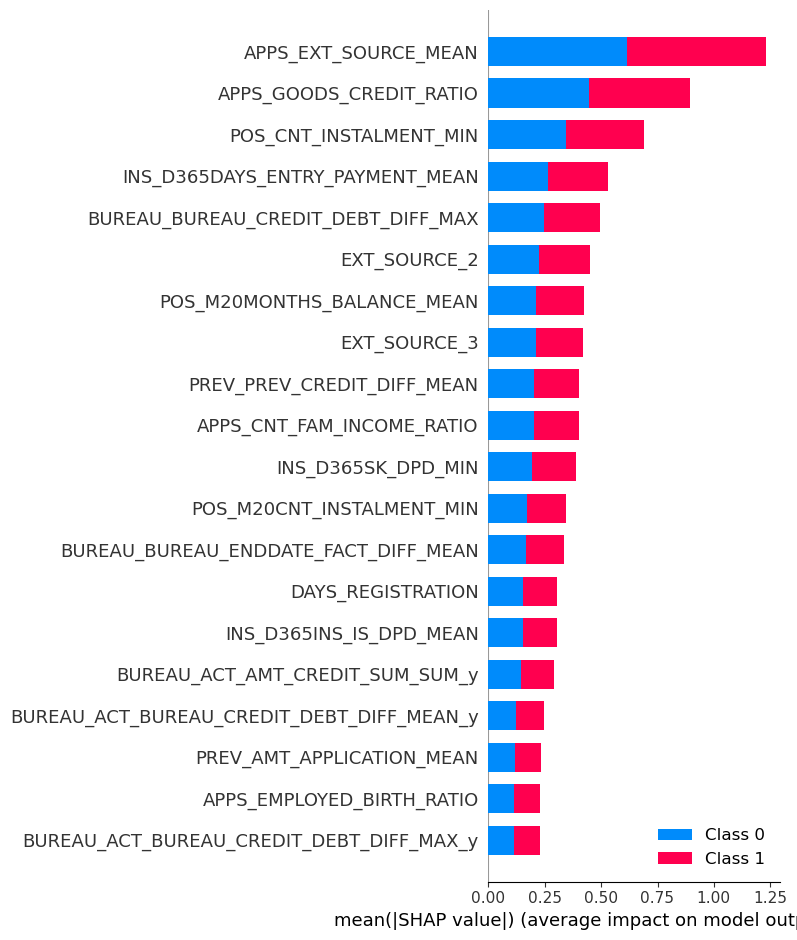

In [87]:
shap.summary_plot(shap_values, X_train_dataframe)

In [12]:
# Model in kaggle kernel
# clf = LGBMClassifier(
    # nthread=4,n_estimators=2000,learning_rate=0.02,max_depth = 11,num_leaves=58,colsample_bytree=0.613,subsample=0.708,
    # ax_bin=407,reg_alpha=3.564,reg_lambda=4.930,min_child_weight= 6,min_child_samples=165,silent=-1,verbose=-1
# )

In [ ]:
# data drift :
# input en live ressemble à ceux sur lesquels je me suis entrainé ? il peut y avoir une différence -> dramatique
# est ce que les features de app train ressemblent a app test ?

In [ ]:
# Noter dans une variable les colonnes que j'ai supprimé dans mon dataset pour les supprimer aussi dans la ligne client que je recevrai
# test unitaire github avec pytest (prediction shap, prediction model)
